In [1]:
import numpy as np
import os
import time
from datetime import datetime
from datetime import timedelta
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames
from sunpy.map.mapbase import GenericMap
from sunpy.map.sources import MDIMap
from sunpy.util.metadata import MetaDict
import numpy as np
import sunpy.map
import matplotlib.pyplot as plt
import warnings
from skimage.measure import label, regionprops,regionprops_table,inertia_tensor_eigvals,inertia_tensor,moments_central,moments_normalized,moments_hu,perimeter
import pandas as pd
import math
import concurrent.futures
import cv2
import imageio

warnings.filterwarnings('ignore')


In [2]:
import porespy as ps

In [3]:
def get_TS(file_name):
    parts = file_name.split('.')
    part = parts[3]
    year = part[0:4]   
    month = part[4:6]
    day = part[6:8]
    hr = part[9:11]
    minute = part[11:13]
    sec = part[13:15]
    iso = year + '-' + month + '-' + day + 'T' + hr + ':' + minute + ':' + sec
    TS = datetime.fromisoformat(iso)
    return TS

In [4]:
def close_files(list_of_files):
    for file in list_of_files:
        file.close()
    pass

In [36]:
def get_magnetogram_files(harp_num, cadence = timedelta(hours = 0, minutes=0, seconds=0), threshold = timedelta(hours = 0, minutes=0, seconds=0)):

    distance = {}
    #print(threshold)
    TS = {}
    TS_list = []
    os.chdir('/data/SHARPS/raw-sharps/' + str(harp_num) + '/')
    #files = os.listdir('.' + '/' + str(harp_num))
    files = os.listdir()
    
    magnetogram_files = sorted([file for file in files if 'magnetogram' in file])
    #print(f'Number of mg files {len(magnetogram_files)}')
    if magnetogram_files == None or magnetogram_files == []:
        return [], []
    first_flag = True
    dictionary_of_files = {}
    for f in magnetogram_files:
        TS[f] = get_TS(f)

    new_TS = get_TS(min(magnetogram_files))
    max_TS = get_TS(max(magnetogram_files))
    #print(new_TS)
    #print(abs((np.array(list(TS.values())) - new_TS)[0]))

    while True:
        distance = abs(np.array(list(TS.values())) - new_TS)
        min_distance = np.amin(distance)
        min_index = np.where(distance == min_distance)
        #print(min_index[0][0])
        if new_TS >= (max_TS + cadence) or cadence == timedelta(hours = 0, minutes= 0, seconds = 0):
            break
        if min_distance <= threshold:
            new_file = list(TS)[min_index[0][0]]
            mp = sunpy.map.Map(new_file)
            if not math.isnan(float(mp.fits_header['LON_MIN'])) and not math.isnan(float(mp.fits_header['LON_MAX'])) and not math.isnan(float(mp.fits_header['LAT_MIN'])) and not math.isnan(float(mp.fits_header['LAT_MAX'])):
                #print(mp.fits_header['LON_MIN'])
                if new_file not in dictionary_of_files:
                    dictionary_of_files[new_file] = mp
                    TS_list += [get_TS(new_file)]

        new_TS += cadence
        
    return TS_list, list(dictionary_of_files.values())

In [6]:
# CRVAL1 = Carrington Longitude at the center of patch
# CRVAL2 = Carrington Latitude at the center of patch
# CRLN_OBS = Carrington Longitude of the Observer (at center of solar disk)
# CRLT_OBS = Carrington Latitude of the Observer (at center of solar disk)
def great_circle_distance(x, y):
    # Calculates the great circle distance (central angle) between
    # Point1: [lat, long]
    # Point2: [lat, long]  = [0, 0] if the angle is required wrt disk center
    # On the surface of a sphere with radius r
    # INPUT UNIT: DEGREES
    x = x * np.pi / 180
    y = y * np.pi / 180
    dlong = x[1] - y[1]
    den = np.sin(x[0]) * np.sin(y[0]) + np.cos(x[0]) * np.cos(y[0]) * np.cos(dlong)
    num = (np.cos(y[0]) * np.sin(dlong)) ** 2 + (
                np.cos(x[0]) * np.sin(y[0]) - np.sin(x[0]) * np.cos(y[0]) * np.cos(dlong)) ** 2
    # Calculate the great circle distance:
    sig = np.arctan2(np.sqrt(num), den) * 180 / np.pi
    return sig
    # print("Heliocentric Angle of point at ", x * 180 / np.pi, " [lat,long] is ", sig, "degrees")
def heliocentric_angle(CRVAL1, CRVAL2, CRLN_OBS, CRLT_OBS):
    # Calculate the Stonyhurst Latitude and Longitude:
    longitude = CRVAL1 - CRLN_OBS
    latitude = CRVAL2 - CRLT_OBS
    x = np.array([latitude, longitude])
    y = np.array([0., 0.])
    return great_circle_distance(x, y)

# Function to calculate radial heliocentric angle of any coordinate on image:
def get_hc_angle(header):
    crval1 = header['CRVAL1']
    crval2 = header['CRVAL2']
    crln_obs = header['CRLN_OBS']
    crlt_obs = header['CRLT_OBS']
    hc_angle =  heliocentric_angle(crval1, crval2, crln_obs, crlt_obs)
    header['HC_ANGLE'] = hc_angle
    return hc_angle

def check_SPEI(TS_list, m_files):
    if TS_list == [] or TS_list == None:
        return [], []
    list_of_files = []
    new_TS_list = []
    for time, value in zip(TS_list, m_files):
        angle = get_hc_angle(value.fits_header)
        #print(f'angle {angle}', end = '')
        if angle < 70:
            #print('approved', end = ' ')
            list_of_files += [value]
            new_TS_list += [time]
        #print()
    return new_TS_list, list_of_files

In [7]:
# def corner_check(TS_list, m_files):
    
#     ls_map = []
#     ls_n_TS = []
    
#     for t, file in zip(TS_list,m_files):
        
#         if np.isnan(file.data).any() == True:
            
#             ob_time = file.fits_header['DATE-OBS']

# #             bl_coor = coord_transformer_hsc(file.bottom_left_coord.lon.deg,file.bottom_left_coord.lat.deg,ob_time)
            
# #             tr_coor = coord_transformer_hsc(file.top_right_coord.lon.deg,file.top_right_coord.lat.deg,ob_time)
            
#             row_y = np.where(np.isnan(file.data))[0]
#             column_x = np.where(np.isnan(file.data))[1]
            
            
#             col_max_idx = column_x.max()
#             row_col_max_idx = row_y[column_x == column_x.max()].min() #most left
            
            
#             col_min_idx = column_x.min()
#             row_col_min_idx = row_y[column_x == column_x.min()].min() #most right
            
            
            
#             a = file.pixel_to_world(col_max_idx*u.pix, row_col_max_idx*u.pix) 
            
#             b = file.pixel_to_world(col_min_idx*u.pix, row_col_min_idx*u.pix)
            
            
            
#             a_coor = coord_transformer_hsc(a.lon.deg,a.lat.deg,ob_time)
            
#             b_coor = coord_transformer_hsc(b.lon.deg,b.lat.deg,ob_time)
            
            
#             a_lat_lon = np.array([a_coor.lat.deg,a_coor.lon.deg])
#             b_lat_lon = np.array([b_coor.lat.deg,b_coor.lon.deg])

#             a_circle_dist = great_circle_distance(a_lat_lon, np.array([0.,0.]))
            
#             b_circle_dist = great_circle_distance(b_lat_lon, np.array([0.,0.]))
            
#             if a_circle_dist < 70 or b_circle_dist < 70:
                
#                 ls_map.append(file)
#                 ls_n_TS.append(t)
            
#         else:
            
#             ls_map.append(file)
#             ls_n_TS.append(t)
            
            

    
#     return ls_n_TS,ls_map
    

In [8]:
# def main_area_corner_check(TS_list, m_files):
    
    
#     ls_map = []
#     ls_n_TS = []
#     ls_mask = []
    
#     for t, file in zip(TS_list,m_files):
        
#         ob_time = file.fits_header['DATE-OBS']

#         bl_coor = coord_transformer_hsc(file.bottom_left_coord.lon.deg,file.bottom_left_coord.lat.deg,ob_time)
            
#         tr_coor = coord_transformer_hsc(file.top_right_coord.lon.deg,file.top_right_coord.lat.deg,ob_time)
        
        
#         main_lat_lon_bl = np.array([file.fits_header['LAT_MIN'],file.fits_header['LON_MIN']])#calculate distance
#         mai_lat_lon_tr = np.array([file.fits_header['LAT_MAX'],file.fits_header['LON_MAX']])
        
#         bl_circle_dist = great_circle_distance(main_lat_lon_bl, np.array([0.,0.]))
#         tr_circle_dist = great_circle_distance(mai_lat_lon_tr, np.array([0.,0.]))
        
        
#         if bl_circle_dist < 70 and tr_circle_dist < 70:
            
#             b_left = coord_transformer_hgc(file.fits_header['LON_MIN'],file.fits_header['LAT_MIN'],file.fits_header['DATE-OBS'])
#             t_right = coord_transformer_hgc(file.fits_header['LON_MAX'],file.fits_header['LAT_MAX'],file.fits_header['DATE-OBS'])
            
            
            
#             bl_pix = file.world_to_pixel(b_left,origin=0)
#             column_idx_bl = int(bl_pix.x.to_value())#columns
#             raw_idx_bl = int(bl_pix.y.to_value())#raw
            
#             tr_pix = file.world_to_pixel(t_right,origin=0)
#             column_idx_tr = int(tr_pix.x.to_value())#columns
#             raw_idx_tr = int(tr_pix.y.to_value())#raw
            
            
            
#             raw_idx = np.arange(raw_idx_bl,raw_idx_tr,step=1)
#             col_idx = np.arange(column_idx_bl,column_idx_tr,step=1)
            
            
#             main_mask = np.zeros(file.data.shape)
            
#             main_mask[raw_idx_bl:raw_idx_tr,column_idx_bl:column_idx_tr] = 1
            
            
#             ls_map.append(file)
#             ls_n_TS.append(t)
#             ls_mask.append(main_mask)
            
    
#     return ls_n_TS,ls_map,ls_mask
                

In [9]:
def patch_corner_check(TS_list, m_files):
    
    ls_map = []
    ls_n_TS = []
    
    for t, file in zip(TS_list,m_files):
        
            
        ob_time = file.fits_header['DATE-OBS']

        bl_coor = coord_transformer_hsc(file.bottom_left_coord.lon.deg,file.bottom_left_coord.lat.deg,ob_time)
            
        tr_coor = coord_transformer_hsc(file.top_right_coord.lon.deg,file.top_right_coord.lat.deg,ob_time)
            
            
            
        a_lat_lon = np.array([bl_coor.lat.deg,bl_coor.lon.deg])#bottom_left
        b_lat_lon = np.array([tr_coor.lat.deg,tr_coor.lon.deg])#top_right

        a_circle_dist = great_circle_distance(a_lat_lon, np.array([0.,0.]))#bottom_left
            
        b_circle_dist = great_circle_distance(b_lat_lon, np.array([0.,0.]))#top_right
            
        if a_circle_dist < 70 and b_circle_dist < 70: #bottom left and top_right corner
                
                ls_map.append(file)
                ls_n_TS.append(t)


    return ls_n_TS,ls_map
    

In [10]:
#Crop the original map to minimum boundingbox area
def coord_transformer_hgc(x,y,obs_time):
    x = x #Stonyhurst longitude
    y = y #Stonyhurst latitude
#     edate = edate
    #c = SkyCoord(-28.9*u.deg, 22.3*u.deg, frame=frames.HeliographicStonyhurst,obstime= obs_time,observer="earth")#)
    #c_hgs = c.transform_to(frames.HeliographicCarrington)
    c = SkyCoord(x*u.deg, y*u.deg, frame=frames.HeliographicStonyhurst,obstime= obs_time, observer="earth")#)
    c_hgs = c.transform_to(frames.HeliographicCarrington)
    return c_hgs #Tx,Ty

def coord_transformer_hsc(x,y,obs_time):
    x = x #Stonyhurst longitude
    y = y #Stonyhurst latitude
#     edate = edate
    #c = SkyCoord(-28.9*u.deg, 22.3*u.deg, frame=frames.HeliographicStonyhurst,obstime= obs_time,observer="earth")#)
    #c_hgs = c.transform_to(frames.HeliographicCarrington)
    c = SkyCoord(x*u.deg, y*u.deg, frame=frames.HeliographicCarrington,obstime= obs_time, observer="earth")#)
    c_hgs = c.transform_to(frames.HeliographicStonyhurst)
    return c_hgs #Tx,Ty



def crop_harp_ar(fits_map):
    
    b_left = coord_transformer_hgc(fits_map.fits_header['LON_MIN'],fits_map.fits_header['LAT_MIN'],fits_map.fits_header['DATE-OBS'])
    t_right = coord_transformer_hgc(fits_map.fits_header['LON_MAX'],fits_map.fits_header['LAT_MAX'],fits_map.fits_header['DATE-OBS'])
    
    fits_submap = fits_map.submap(b_left, t_right)#SkyCoord of bottom left and Top Right
    
    return fits_submap

def harp_ar(fits_map):
    
    b_left = coord_transformer_hgc(fits_map.fits_header['LON_MIN'],fits_map.fits_header['LAT_MIN'],fits_map.fits_header['DATE-OBS'])
    t_right = coord_transformer_hgc(fits_map.fits_header['LON_MAX'],fits_map.fits_header['LAT_MAX'],fits_map.fits_header['DATE-OBS'])
    
#     fits_submap = fits_map.submap(b_left, t_right)#SkyCoord of bottom left and Top Right
    
    return b_left,t_right

        
# def sub_map_data_check(TS_list,ls_fits):
    
#     ls_submap = []
#     ls_n_TS = []
    
#     for t, file in zip(TS_list,ls_fits):
        
#         sub_map = crop_harp_ar(file)
        
#         if np.isnan(sub_map.data).any() == False:
            
#             ls_submap.append(sub_map)
            
#             ls_n_TS.append(t)
    
#     return ls_n_TS,ls_submap
            


In [11]:
coord_transformer_hgc(-28.986671, -22.301321, '2014-10-22 21:10:15')

<SkyCoord (HeliographicCarrington: obstime=2014-10-22T21:10:15.000, observer=<HeliographicStonyhurst Coordinate for 'earth'>): (lon, lat, radius) in (deg, deg, km)
    (227.00107562, -22.301321, 695700.)>

In [12]:
# return positive and negative polarity region with gauss threshold

def identify_pos_neg_region(fits_map, pos_gauss = 100, neg_gauss= -100):
    
    pos_map = np.zeros(fits_map.data.shape)
    neg_map = np.zeros(fits_map.data.shape)
    
    np.warnings.filterwarnings('ignore')
    result_pos = np.where(fits_map.data >= pos_gauss)
    result_neg = np.where(fits_map.data <= neg_gauss)
    
    pos_map[result_pos[0],result_pos[1]] = 1
    neg_map[result_neg[0],result_neg[1]] = 1
    
    
    return pos_map, neg_map
  

In [13]:
#edge detection 
from skimage import feature

def edge_detection(binary_map):
    
    sig = 1
    
#     sigma: float, optional
# Standard deviation of the Gaussian filter.

# low_threshold: float, optional
# Lower bound for hysteresis thresholding (linking edges). If None, low_threshold is set to 10% of dtype’s max.

# high_threshold: float, optional
# Upper bound for hysteresis thresholding (linking edges). If None, high_threshold is set to 20% of dtype’s max.

# mask: array, dtype=bool, optional
# Mask to limit the application of Canny to a certain area.
    
    edges = feature.canny(binary_map, sigma = sig)
    
    return edges

In [14]:
# buffer detected edge
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image,thin
from skimage.morphology import (square, rectangle, diamond, disk, cube,
                                octahedron, ball, octagon, star)

def buff_edge(edges, size = 4):
    
    selem = square(size)
    
    dilated_edges = dilation(edges, selem)
    
    return dilated_edges


In [15]:
#pil_extraction
def pil_extraction(buff_pos, buff_neg,fits_map,thinning = True):
    
    pil_mask = np.invert(np.isnan(fits_map.data))
#     m_mask = m_mask.astype(bool)
    
    pil_result = np.where(buff_pos & buff_neg & pil_mask) #index(pixel) coordinates of PIL intersection
    
    pil_map = np.zeros(fits_map.data.shape)

    pil_map[pil_result[0],pil_result[1]] = 1
    
    if thinning == True:
        
        thinned_pil = thin(pil_map)
        
        print("thinning PIL")
        
        return thinned_pil
    
    else:
        
        print("blank PIL")
        
        return pil_map

In [16]:
def PIL_dataframe(lst_pil):
    
    #first step pil_dataframe
    
    #input: list of original PIL
    #output: list of pil dataframe
    #        list of pil label
    ls_pil_df = []
    
    ls_ob_labels = []
    
    
    for i, file in enumerate(lst_pil):
        
        if (np.all(file == False)):
            
            ls_pil_df.append(None)
            ls_ob_labels.append(None)
            
        else:
            
            ob_labels = label(file,connectivity=2)
        
            prop = ['label','centroid','orientation','major_axis_length','minor_axis_length','bbox', 'area','coords','image','bbox_area']
        
            props_table = regionprops_table(ob_labels, properties = prop)
                                           
            
            ls_pil_df.append(pd.DataFrame(props_table))
            
            ls_ob_labels.append(ob_labels)
            
    
    
    return ls_pil_df,ls_ob_labels #return the list of original pil dataframe and pil label list
        
        

In [17]:
def PIL_series(TS_list, ls_map, pos_g_val = 100, neg_g_val = -100):
    
#     pil_series_thin = []
    new_TS_list = []

    
    pil_series_not_thin = []
    
#     sub_map_lst = []
    
    success_count = 0
    
    for i,sub_map in enumerate(ls_map):
        

        
        pos_map, neg_map = identify_pos_neg_region(sub_map, pos_gauss = pos_g_val, neg_gauss= neg_g_val)
        
        pos_edge = edge_detection(pos_map)

        neg_edge = edge_detection(neg_map)
        
        pos_dil_edge = buff_edge(pos_edge, size = 4)

        neg_dil_edge = buff_edge(neg_edge, size = 4)
        
#         pil_final_thin = pil_extraction(pos_dil_edge, neg_dil_edge,sub_map,thinning = True)
        
        pil_final_not_thin = pil_extraction(pos_dil_edge, neg_dil_edge,sub_map,thinning = False)
        
#         pil_series_thin.append(pil_final_thin)
        
        pil_series_not_thin.append(pil_final_not_thin)
        
#         sub_map_lst.append(sub_map)
        new_TS_list += [TS_list[i]]

        
        success_count += 1
        
        print("PIL complete: {h_num}_{h_d}".format(h_num = sub_map.fits_header['HARPNUM'],h_d = sub_map.fits_header['DATE-OBS']))
        
    print("Success: ",success_count)
        
    print("Fail: ", len(ls_map) - success_count )
        
    return new_TS_list, pil_series_not_thin #return the PIL series (not thinning) and submap of single HARP number
        
        
        

In [18]:
def single_strength(pil_df_n,submap_series_n):
    
    # e.g. pil_df_n = ls_pil_4698_orig[37]
    
    #     submap_series_n = submap_4698[37]
    
    #calculate the total Gauss of each PIL: currently use: sum(abs(pil[row,column].data))
    
    pil_strgt_lst = []
    
    for i,pil_row in pil_df_n.iterrows():
        
        r_idx = pil_row.coords[:,0]
        col_idx = pil_row.coords[:,1]
        
        
        pil_strength = sum(abs(submap_series_n.data[r_idx,col_idx]))#single strength
        
        pil_strgt_lst.append(pil_strength)
        
    return pil_strgt_lst

In [19]:
def single_strength_column(lst_pil_df,lst_submap_series):
    
    # add strength column to each PIL dataframe
    
    for i,pil_df in enumerate(lst_pil_df):
        
        pil_df['strength'] = single_strength(pil_df,lst_submap_series[i])

    

In [20]:
def trend_cut_ls(lst_pil_df):
    
    # decending the PIL by strength, then use cumulative sum to calculate percent of PIL gauss
    
    for i,pil_df in enumerate(lst_pil_df):
        
        pil_df.sort_values(by=['strength'],ascending=False,inplace=True)
        
        pil_df['cum_percent'] = pil_df['strength'].cumsum()/sum(abs(pil_df['strength'])) #generate ['cum_percent'] column
        
        pil_df['str_percent'] = pil_df['strength']/ sum(abs(pil_df['strength']))
        
        pil_df['cut_threshold'] = pil_df['cum_percent'] - pil_df['str_percent']
        
        

In [21]:
def filter_strength_pil(pil_df,s_t,pil_label):
    
    #single dataframe
    
    cut_label = pil_df[pil_df['cut_threshold'] > s_t].label.values  #threshold which contains 90% ~95% PIL flux
    
    cut_idx = np.isin(pil_label,cut_label) #idividual pil which total strength not initial total flux
    
    
    pil_label[cut_idx] = 0 #set small PIL flux label to 0, only keep big PIL flux label
    
    return pil_label
    


In [22]:
def filter_str_pil_lst(ls_pil_df,ls_label):
    
    """
    input: list of PIL dataframe
           list of PIL label
    """
    
    n_object_label_lst = []
    
    for i,pil_df in enumerate(ls_pil_df):
        

        n_label = filter_strength_pil(pil_df,0.95,ls_label[i]) #give the threshold to filter the PIL based on Magnetic Flux
    
        n_object_label_lst.append(n_label)
        
    
    return n_object_label_lst
    

In [23]:
def label_conn_thin(filtered_orig_label):
    
    pil_thin = thin(filtered_orig_label) #thin the original filttered label matrix, return the binary mask
    
    filtered_orig_label[~pil_thin] = 0 #keep the original label, and set non-thining part as 0
    
    return filtered_orig_label #return the label mask after thinning after_thin_label(keep the same label id as before_thinning)
    

In [24]:
def lst_after_thin_label(ls_pil_orig, ls_orig_label):
    
    ls_thin_label = []
    
    for i, pil_filter_orig in enumerate(ls_pil_orig):
        
        thin_label = label_conn_thin(pil_filter_orig,ls_orig_label[i])
        
        ls_thin_label.append(thin_label) #append filttering label and prepare thinned pil dataframe
        
    return ls_thin_label

In [25]:
def filtering_by_strength(ls_pil_df, ls_pil_label, ls_orig_pil,ls_submap,threshold = 0.95):
    
    
    ls_n_filtering_label = []
    
    for i,file in enumerate(ls_pil_df):
        
        if file is not None:
            
            file['strength'] = single_strength(file,ls_submap[i])
            
            file.sort_values(by=['strength'],ascending=False,inplace=True)
        
            file['cum_percent'] = file['strength'].cumsum()/sum(abs(file['strength'])) #generate ['cum_percent'] column
        
            file['str_percent'] = file['strength']/ sum(abs(file['strength']))
        
            file['cut_threshold'] = file['cum_percent'] - file['str_percent'] #cut threshold (handle if exist minority PIL)
            
            file['strength_keep'] = file.apply(lambda row: row.cut_threshold <= threshold, axis = 1)
            
            n_label = filter_strength_pil(file,threshold,ls_pil_label[i])#return the label matrix satisfy the filtering threshold
            

            
            
            ls_n_filtering_label.append(n_label)
        
        else:
            
            ls_n_filtering_label.append(None)
            
    
    return ls_n_filtering_label # return filtering(by strength) label matrix
            
            


In [26]:
def thining_strength_label(ls_filter_label):
    
    ls_strength_binary_image = []
    
    ls_thin_dataframe = []
    
    ls_thin_binary_image = []
    
    for i,file in enumerate(ls_filter_label):
        
        if file is not None:
            
            
            
            ls_strength_binary_image.append(np.zeros(file.shape) + file)
        
            pil_thin_label = label_conn_thin(file)
        
            prop = ['label','centroid','orientation','major_axis_length','minor_axis_length','bbox', 'area','coords','image','bbox_area','perimeter','convex_area']
        
            props_table = regionprops_table(pil_thin_label, properties = prop)
            
            thin_binary = pil_thin_label
            
            
            ls_thin_dataframe.append(pd.DataFrame(props_table))
            
            ls_thin_binary_image.append(thin_binary)
            
        
        else:
            
            ls_strength_binary_image.append(None)
            
            ls_thin_dataframe.append(None)
            
            ls_thin_binary_image.append(None)
            
    
    return ls_strength_binary_image,ls_thin_dataframe, ls_thin_binary_image


In [27]:
def filtering_by_thinned_length(ls_thin_df, ls_thin_b_image,thin_threshold = 14):
    

    
    for i,file in enumerate(ls_thin_df):
        
        if file is not None:
        
            cut_thin_label = file[file['area'] < thin_threshold].label.values #filter pil by length threshold
            
            file['length_keep'] = file.apply(lambda row: row.area >= thin_threshold, axis = 1)
        
            if len(cut_thin_label) > 0:
                
                
                cut_idx = np.isin(ls_thin_b_image[i],cut_thin_label)
                
                
                ls_thin_b_image[i][cut_idx] = 0 #remove thinned length after filtering
                
    
    return ls_thin_b_image #return list of length filtering binary PIL image with label
                
        


In [28]:
def filter_strength_length(thin_df):
    
    #filter pil based on length keep label
    
#     s_label = set(list(orig_strength_df[orig_strength_df['strength_keep'] == True].label.values))
    
    thin_label = set(list(thin_df[thin_df['length_keep'] == True].label.values))
    
    final_label = list(thin_label)
    
    return final_label

In [29]:
def get_final_bib_pil(s_filter_b_image, final_label):
    
    
    f_lab_matrix = np.zeros(s_filter_b_image.shape) + s_filter_b_image
    
    remove_idx = np.isin(f_lab_matrix,final_label,invert=True) #
    
    f_lab_matrix[remove_idx] = 0 # final binary image of PIL (after strength and thinning)
    
    return f_lab_matrix
    

In [30]:
def get_convex_image(pil_binary):
    
    convex_b = convex_hull_image(pil_binary).astype('int')
    
    return convex_b



In [31]:
def ls_final_pil(ls_filter_thin_df,ls_s_filter_b):
    
    #input: list of filter thinned df
    #       list of 
    
    ls_final_binary_PIL = []
    
    ls_final_convex_PIL = []
    
    for i, file in enumerate(ls_filter_thin_df):
        
        if file is not None:
            
            f_label = filter_strength_length(file)
            
            f_lab_matrix = get_final_bib_pil(ls_s_filter_b[i], f_label)
            
            f_conv_image = get_convex_image(f_lab_matrix)
            
            ls_final_binary_PIL.append(f_lab_matrix)
            
            ls_final_convex_PIL.append(f_conv_image)
            
        
        else:
            
            ls_final_binary_PIL.append(None)
            
            ls_final_convex_PIL.append(None)
            
    
    
    return ls_final_binary_PIL,ls_final_convex_PIL
            
            

In [32]:
def df_merge(ls_str_df, ls_thin_df):
    
    ls_merge_df = []
    
    
    for i,file in enumerate(ls_str_df):
        
        if file is not None:
            
            
            thin_str_df = ls_thin_df[i].merge(file, left_on='label', right_on='label',suffixes=('_thin', '_strength'))
            
            
            
            ls_merge_df.append(thin_str_df[thin_str_df['length_keep'] == True]) #select length and strength == True
            
        
        else:
            
            ls_merge_df.append(None)
            
    
    return ls_merge_df
            

In [33]:
def convex_df(ls_final_convex):
    
    ls_convex_df = []
    
    for i,file in enumerate(ls_final_convex):
        
       
        if i == 2:
            print(type(file))
        if file is not None:
            
            ob_labels = label(file,connectivity=2)

            prop = ['label','centroid','orientation','major_axis_length','minor_axis_length','bbox', 'area','coords','image','bbox_area','perimeter']
            
            props_table = regionprops_table(ob_labels, properties = prop)

            ls_convex_df.append(pd.DataFrame(props_table))

        
        
        else:
            ls_convex_df.append(None)
            
        
    return ls_convex_df
            
 

In [34]:
def convex_pil_thin(ls_pil_thin_final):
    
    ls_convex_df = []
    ls_convex_thin_b = []
    
    
    for i,file in enumerate(ls_pil_thin_final):
        
        if file is not None:
            
            f_conv_image = get_convex_image(file)
            
            ob_labels = label(f_conv_image,connectivity=2)

            prop = ['label','centroid','orientation','major_axis_length','minor_axis_length','bbox', 'area','coords','image','bbox_area','perimeter']
            
            props_table = regionprops_table(ob_labels, properties = prop)

            ls_convex_df.append(pd.DataFrame(props_table))
            
            ls_convex_thin_b.append(f_conv_image)
            
        
        else:
            
            ls_convex_df.append(None)
            
            ls_convex_thin_b.append(None)
            
    
    
    return ls_convex_df,ls_convex_thin_b
            
    

### I. Validation for HARP Patch

In [37]:
cadence = timedelta(hours = 3, minutes= 0, seconds = 0)
threshold = timedelta(hours = 0, minutes= 0, seconds = 0)
TS_list, ls_files = get_magnetogram_files(1879, cadence, threshold)



In [38]:
#def check_SPEI(TS_list, ls_files): check if heliocentric angle of centroid of HARP Patch is less than 70
TS_list, ls_files = check_SPEI(TS_list, ls_files)




In [39]:
#def patch_corner_check(TS_list, ls_file): furcher check if bottom left, top right corner of HARP Patch is less than 70
TS_list, ls_files = patch_corner_check(TS_list, ls_files)

In [40]:
len(ls_files)

39

In [41]:
len(TS_list)

39

### II. PIL Detection Procedure

### a. Detect PIL based on initial Gauss

In [42]:
TS_list, PIL_series_orig_n = PIL_series(TS_list, ls_files,pos_g_val = 100, neg_g_val = -100)


# submap_n[0].data.shape

blank PIL
PIL complete: 1879_2012-07-29T09:10:25.20
blank PIL
PIL complete: 1879_2012-07-29T12:10:25.10
blank PIL
PIL complete: 1879_2012-07-29T15:10:25.10
blank PIL
PIL complete: 1879_2012-07-29T18:10:25.00
blank PIL
PIL complete: 1879_2012-07-29T21:10:25.00
blank PIL
PIL complete: 1879_2012-07-30T00:10:25.00
blank PIL
PIL complete: 1879_2012-07-30T03:10:25.10
blank PIL
PIL complete: 1879_2012-07-30T06:10:25.20
blank PIL
PIL complete: 1879_2012-07-30T09:10:25.20
blank PIL
PIL complete: 1879_2012-07-30T12:10:25.10
blank PIL
PIL complete: 1879_2012-07-30T15:10:25.00
blank PIL
PIL complete: 1879_2012-07-30T18:10:24.90
blank PIL
PIL complete: 1879_2012-07-30T21:10:24.90
blank PIL
PIL complete: 1879_2012-07-31T00:10:25.00
blank PIL
PIL complete: 1879_2012-07-31T03:10:25.00
blank PIL
PIL complete: 1879_2012-07-31T06:10:25.10
blank PIL
PIL complete: 1879_2012-07-31T09:10:25.10
blank PIL
PIL complete: 1879_2012-07-31T12:10:25.00
blank PIL
PIL complete: 1879_2012-07-31T15:10:24.90
blank PIL
PI

In [43]:
# crop_harp_ar(ls_files[0])

In [44]:
# a_lat_lon = np.array([a_coor.lat.deg,a_coor.lon.deg])

# great_circle_distance(a_lat_lon, np.array([0.,0.]))

In [45]:
# np.array([a_coor.lat.deg,a_coor.lon.deg])

In [46]:
# ls_files[67].bottom_left_coord.lon.deg

In [47]:
# ls_files[67].bottom_left_coord.lat.deg

In [48]:
# ls_files[67].top_right_coord.lon.deg

In [49]:
# ls_files[67].top_right_coord.lat.deg

In [50]:
# np_mask = np.zeros(ls_files[6].data.shape)

In [51]:
# ls_files[44].plot()

In [52]:
# print(submap_n[0].data.max())
# print(submap_n[0].data.min())
# submap_n[0].plot()

In [53]:
# np.isnan(submap_n[69].data).any()

In [54]:
# submap_n[68].fits_header

In [55]:
ls_pil_orig_n,ls_label_orig_n = PIL_dataframe(PIL_series_orig_n)

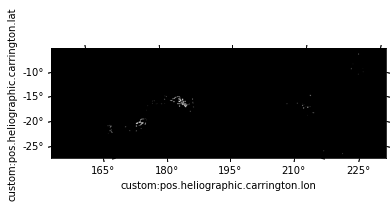

In [56]:
ax_orig_test = plt.subplot(projection = ls_files[0])
ax_orig_test.imshow(ls_label_orig_n[0].astype(bool),cmap=plt.cm.gray)

In [57]:
ls_pil_orig_n[0]

label  centroid-0   centroid-1  orientation  major_axis_length  \
0       1   30.272727  2009.545455     0.053368           6.410748   
1       2   48.909091  1879.272727     1.146031           5.196737   
2       3  169.500000   394.000000     0.000000           4.472136   
3       4  179.333333   418.904762    -0.341565          18.086222   
4       5  186.250000   587.500000     0.662909           6.777232   
..    ...         ...          ...          ...                ...   
69     70  614.235294  2069.117647     0.234066           9.176795   
70     71  614.000000  2150.000000     0.785398           0.000000   
71     72  616.000000  2149.000000     0.785398           0.000000   
72     73  647.000000  2081.000000     0.000000           3.265986   
73     74  715.105263  2119.578947    -0.223760           5.544698   

    minor_axis_length  bbox-0  bbox-1  bbox-2  bbox-3  area  \
0            1.964940      28    2009      34    2011    11   
1            2.565289      48    1877      51    1882    11   
2            0.000000     168     394     172     395     4   
3            5.530346     174     417     189     426    42   
4            4.131480     183     586     189     591    20   
..                ...     ...     ...     ...     ...   ...   
69           2.629537     611    2068     620    2071    17   
70           0.000000     614    2150     615    2151     1   
71           0.000000     616    2149     617    2150     1   
72           0.000000     646    2081     649    2082     3   
73           4.295695     713    2118     718    2122    19   

                                               coords  \
0   [[28, 2009], [28, 2010], [29, 2009], [29, 2010...   
1   [[48, 1877], [48, 1878], [48, 1879], [48, 1880...   
2    [[168, 394], [169, 394], [170, 394], [171, 394]]   
3   [[174, 420], [174, 421], [174, 422], [174, 423...   
4   [[183, 586], [184, 586], [184, 587], [185, 586...   
..                                                ...   
69  [[611, 2068], [611, 2069], [612, 2068], [612, ...   
70                                      [[614, 2150]]   
71                                      [[616, 2149]]   
72            [[646, 2081], [647, 2081], [648, 2081]]   
73  [[713, 2119], [713, 2120], [713, 2121], [714, ...   

                                                image  bbox_area  
0   [[True, True], [True, True], [True, True], [Tr...         12  
1   [[True, True, True, True, False], [False, True...         15  
2                    [[True], [True], [True], [True]]          4  
3   [[False, False, False, True, True, True, True,...        135  
4   [[True, False, False, False, False], [True, Tr...         30  
..                                                ...        ...  
69  [[True, True, False], [True, True, False], [Tr...         27  
70                                           [[True]]          1  
71                                           [[True]]          1  
72                           [[True], [True], [True]]          3  
73  [[False, True, True, True], [True, True, True,...         20  

[74 rows x 14 columns]

### b. Filtering by Magnititude Field Strength

In [58]:
ls_n_label = filtering_by_strength(ls_pil_orig_n, ls_label_orig_n, PIL_series_orig_n,ls_files,threshold = 0.95)


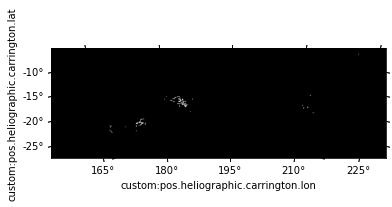

In [59]:
ax_str_test = plt.subplot(projection = ls_files[0])
ax_str_test.imshow(ls_n_label[0].astype(bool),cmap=plt.cm.gray)

In [60]:
ls_strength_binary_image, ls_thin_df, ls_thin_binary = thining_strength_label(ls_n_label)


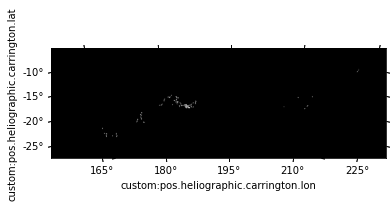

In [61]:
ax_filter_test = plt.subplot(projection = ls_files[15])
ax_filter_test.imshow(ls_strength_binary_image[15].astype(bool),cmap=plt.cm.gray)

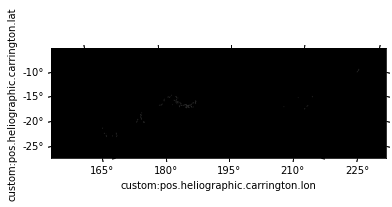

In [62]:
ax_thin_test = plt.subplot(projection = ls_files[15])
ax_thin_test.imshow(ls_thin_binary[15].astype(bool),cmap=plt.cm.gray)

### c. Filtering by number of contiguous pixel which PIL corvers 

In [63]:
ls_thin_filter_b_image = filtering_by_thinned_length(ls_thin_df, ls_thin_binary,thin_threshold = 14)


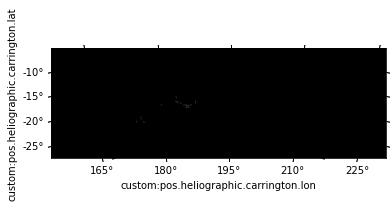

In [64]:
ax_thin_filter_test = plt.subplot(projection = ls_files[15])
ax_thin_filter_test.imshow(ls_thin_filter_b_image[15].astype(bool),cmap=plt.cm.gray)

In [65]:
# ls_pil_orig_n[75].cut_threshold > 0.95

In [66]:
ls_thin_df[15]

label  centroid-0   centroid-1  orientation  major_axis_length  \
0       1  150.000000   452.909091     0.406102          13.762147   
1       2  151.000000   380.692308    -0.180779          15.205212   
2       3  151.500000   423.833333     0.145728           6.902545   
3       4  167.000000   449.461538    -0.078547          15.011869   
4       5  166.000000   382.000000     0.785398           0.000000   
5       6  169.375000   368.125000    -1.088517           7.972819   
6       8  204.857143   354.857143     0.518747           8.229060   
7      10  246.647059   640.117647    -0.673746          11.930995   
8      12  250.357143   591.857143     0.476334          17.195570   
9      13  264.875000   597.625000    -0.655097           7.221857   
10     14  274.590909   620.772727    -0.301242          25.967553   
11     15  293.100000   621.800000     0.796426          14.055028   
12     16  298.000000   616.875000     1.140354           6.436090   
13     18  310.200000   624.800000    -0.366408           4.895949   
14     23  338.333333  1747.666667     0.785398           9.797959   
15     24  348.480000   932.720000    -0.843278          12.885193   
16     25  359.120000   954.140000     0.748714          39.683069   
17     26  347.000000   971.000000    -0.392699           6.107531   
18     29  351.000000   980.200000    -0.205064           5.773311   
19     31  355.500000   885.250000    -0.218669          14.142136   
20     32  353.000000  1605.000000     0.000000           5.656854   
21     33  362.816327   928.224490    -1.353745          41.659717   
22     34  354.272727   967.000000     1.570796           7.032393   
23     36  357.500000   924.000000     0.000000           2.000000   
24     38  358.090909  1766.909091     0.948189          14.866282   
25     39  361.100000   898.500000    -1.360048          11.732332   
26     42  363.250000   748.500000     1.426769           9.259610   
27     43  367.000000   762.133333     0.813665          17.801546   
28     44  366.500000   837.000000     0.553574           5.236068   
29     47  366.250000   894.750000    -0.785398           4.472136   
30     50  372.800000   867.600000    -0.711859           6.055460   
31     52  373.000000   995.500000     1.570796           4.472136   
32     55  378.133333   891.733333    -0.848612          17.856138   
33     58  378.384615   979.692308     1.271530          12.131296   
34     59  383.789474   873.684211    -0.366869          14.442737   
35     60  385.720000   996.320000     0.054754          22.387652   
36     61  388.000000   861.684211    -0.055143          21.941763   
37     63  395.500000   778.700000    -0.127743          11.582652   
38     64  396.444444   849.444444    -1.060591           7.739554   
39     67  402.666667   864.666667    -1.325818           6.110101   
40     68  404.600000   781.000000     0.950547           6.928203   
41     71  418.625000   863.812500    -0.647052          17.567045   
42     72  412.500000   874.250000     0.629899           5.495948   
43     73  415.500000  1703.500000     0.785398           6.324555   
44     74  418.250000   817.666667     0.793789          14.397614   
45     75  419.777778   807.000000     1.245003          10.893964   
46     76  422.000000  1800.714286    -0.179974           8.128920   
47     77  431.333333   829.833333     0.730473           7.913767   
48     81  594.400000  2111.300000     0.639585          13.530512   
49     82  606.230769  2120.384615     0.287647          14.348613   

    minor_axis_length  bbox-0  bbox-1  bbox-2  bbox-3  area  \
0            1.008235     145     451     156     456    11   
1            2.918474     145     379     158     383    13   
2            1.115241     149     423     155     425     6   
3            2.254254     161     449     174     452    13   
4            0.000000     166     382     167     383     1   
5            4.234874     167     365     172     371  

### d. Final RoPI and convex hull of RoPI

In [67]:
ls_final_b_pil,ls_final_convex_pil = ls_final_pil(ls_thin_df,ls_strength_binary_image)


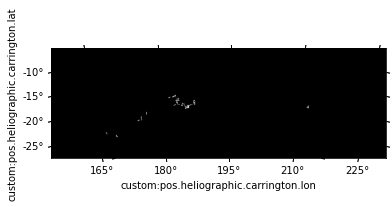

In [68]:
ax_final_test = plt.subplot(projection = ls_files[11])
ax_final_test.imshow(ls_final_b_pil[11].astype(bool),cmap=plt.cm.gray)

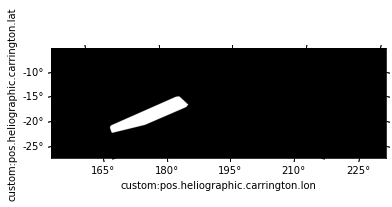

In [69]:
ax_final_convex_test = plt.subplot(projection = ls_files[0])
ax_final_convex_test.imshow(ls_final_convex_pil[0].astype(bool),cmap=plt.cm.gray)

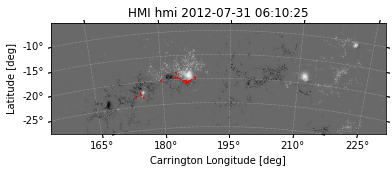

In [70]:
# map_ = ls_thin_filter_b_image[20].astype(bool) #run 1000

ls_files[15].plot()
plt.contour(ls_thin_filter_b_image[15].astype(bool),antialiased=True,colors='red',linewidths=0.2)


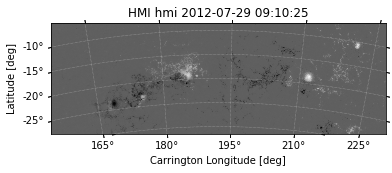

In [71]:
ls_files[0].plot()

In [72]:
#Merge Strength and Thinning df (after applying filter)
ls_str_thin_df = df_merge(ls_pil_orig_n, ls_thin_df)

In [73]:
ls_str_thin_df[0]

label  centroid-0_thin  centroid-1_thin  orientation_thin  \
0       4       179.578947       419.105263         -0.438916   
3      10       215.045455       410.636364          0.505103   
8      16       249.600000       621.421053          0.346924   
9      17       235.000000       649.466667          0.356771   
10     18       239.000000       592.000000          1.178097   
15     28       363.679245       928.905660          1.316890   
18     36       373.217391       911.434783          1.344651   
21     50       385.139535       905.023256          1.038698   
23     54       401.688889       888.288889          0.001926   
25     58       395.117647       828.000000         -1.428398   
30     64       418.790698       869.162791          1.354747   

    major_axis_length_thin  minor_axis_length_thin  bbox-0_thin  bbox-1_thin  \
0                20.717193                5.711934          174          417   
3                23.143614                4.636496          206          407   
8                52.434476               31.649522          225          606   
9                18.439462                1.017405          228          647   
10                8.290589                6.033986          237          589   
15               26.946303               19.694716          353          919   
18               32.408601               10.341437          367          897   
21               25.715407               18.751186          376          895   
23               31.369637               15.402587          389          880   
25               19.794602                1.801779          394          820   
30               49.779492                9.974059          409          850   

    bbox-2_thin  bbox-3_thin  ...  bbox-3_strength area_strength  \
0           189          426  ...              426            42   
3           225          415  ...              416            52   
8           270          642  ...              643           413   
9           243          653  ...              654            54   
10          242          596  ...              600           110   
15          374          945  ...              946           246   
18          378          929  ...              929           175   
21          394          915  ...              917           143   
23          417          896  ...              898           253   
25          397          837  ...              838            56   
30          424          891  ...              891           148   

                                      coords_strength  \
0   [[174, 420], [174, 421], [174, 422], [174, 423...   
3   [[206, 407], [207, 407], [207, 408], [208, 408...   
8   [[224, 616], [224, 617], [225, 616], [225, 617...   
9   [[228, 647], [229, 647], [229, 648], [230, 647...   
10  [[234, 586], [234, 587], [234, 588], [234, 589...   
15  [[350, 926], [350, 927], [350, 928], [350, 929...   
18  [[365, 906], [365, 907], [365, 908], [365, 909...   
21  [[376, 895], [377, 895], [378, 895], [378, 896...   
23  [[386, 882], [386, 883], [386, 884], [386, 885...   
25  [[393, 829], [393, 830], [393, 831], [393, 832...   
30  [[407, 848], [407, 849], [407, 850], [408, 848...   

                                       image_strength  bbox_area_strength  \
0   [[False, False, False, True, True, True, True,...                 135   
3   [[True, False, False, False, False, False, Fal...                 171   
8   [[False, False, False, False, False, False, Fa...                1794   
9   [[True, False, False, False, False, False, Fal...                 112   
10  [[True, True, True, True, True, True, False, F...                 154   
15  [[False, False, False, False, False, False, Fa...                 672   
18  [[False, False, False, False, False, False, Fa...                 448   
21  [[True, False, False, False, False, False, Fal...                 396   
23  [[False, False, False, False, True, True, True...              

In [74]:
# ls_final_convex_pil[0]

39

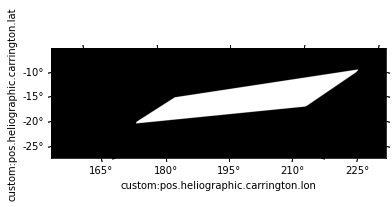

In [75]:
ax_final_convex_test = plt.subplot(projection = ls_files[20])
ax_final_convex_test.imshow(ls_final_convex_pil[20].astype(bool),cmap=plt.cm.gray)
len(ls_final_convex_pil)

In [76]:
ls_final_covex_df = convex_df(ls_final_convex_pil)



<class 'numpy.ndarray'>


### e.  Final convex hull of PIL

In [77]:
#convex hull df of PIL, and dataframe of convex hull PIL
ls_convex_pil_df, ls_convex_pil_thin = convex_pil_thin(ls_thin_filter_b_image)#Input: final_PIL(thinned)

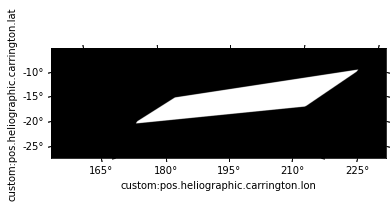

In [78]:
ax_final_convex_pil = plt.subplot(projection = ls_files[20])
ax_final_convex_pil.imshow(ls_convex_pil_thin[20].astype(bool),cmap=plt.cm.gray)

In [79]:
ls_convex_pil_df[20]

label  centroid-0   centroid-1  orientation  major_axis_length  \
0      1   408.51249  1362.910789     1.405075        1483.474003   

   minor_axis_length  bbox-0  bbox-1  bbox-2  bbox-3    area  \
0         197.169804     238     587     609    2118  217216   

                                              coords  \
0  [[238, 587], [238, 588], [238, 589], [238, 590...   

                                               image  bbox_area    perimeter  
0  [[True, True, True, True, True, True, False, F...     568001  3371.204328

In [80]:
# #store image
# img_uint8 = ls_convex_pil_thin[20].astype(np.uint8)
# imageio.imwrite('filename.png', img_uint8)

PermissionError: [Errno 13] Permission denied: '/data/SHARPS/raw-sharps/1879/filename.png'

In [81]:
ls_str_thin_df[20]['area_thin'].sum()

172

In [82]:
ls_final_covex_df[15]

label  centroid-0  centroid-1  orientation  major_axis_length  \
0      1    336.0788  802.782129     1.215091         423.153401   

   minor_axis_length  bbox-0  bbox-1  bbox-2  bbox-3   area  \
0          99.594606     243     589     424    1001  30977   

                                              coords  \
0  [[243, 614], [243, 615], [243, 616], [243, 617...   

                                               image  bbox_area   perimeter  
0  [[False, False, False, False, False, False, Fa...      74572  985.175757

In [83]:
ls_pil_orig_n[0]

label  centroid-0   centroid-1  orientation  major_axis_length  \
15     16  247.116223   621.707022     0.220148          49.986692   
53     54  397.656126   887.237154    -0.052969          30.601820   
27     28  361.524390   927.784553     1.108429          25.517568   
35     36  372.182857   911.011429     1.352053          31.540253   
63     64  417.385135   866.175676     1.296681          54.915723   
..    ...         ...          ...          ...                ...   
20     21  293.666667  1767.666667     0.785398           2.309401   
41     42  372.000000   724.500000     1.570796           4.472136   
47     48  375.000000   785.000000     0.785398           0.000000   
70     71  614.000000  2150.000000     0.785398           0.000000   
71     72  616.000000  2149.000000     0.785398           0.000000   

    minor_axis_length  bbox-0  bbox-1  bbox-2  bbox-3  area  \
15          34.571646     224     604     270     643   413   
53          20.505702     386     878     417     898   253   
27          22.085659     350     918     374     946   246   
35          13.060340     365     897     379     929   175   
63          10.859874     407     848     424     891   148   
..                ...     ...     ...     ...     ...   ...   
20           1.333333     293    1767     295    1769     3   
41           0.000000     372     723     373     727     4   
47           0.000000     375     785     376     786     1   
70           0.000000     614    2150     615    2151     1   
71           0.000000     616    2149     617    2150     1   

                                               coords  \
15  [[224, 616], [224, 617], [225, 616], [225, 617...   
53  [[386, 882], [386, 883], [386, 884], [386, 885...   
27  [[350, 926], [350, 927], [350, 928], [350, 929...   
35  [[365, 906], [365, 907], [365, 908], [365, 909...   
63  [[407, 848], [407, 849], [407, 850], [408, 848...   
..                                                ...   
20            [[293, 1768], [294, 1767], [294, 1768]]   
41   [[372, 723], [372, 724], [372, 725], [372, 726]]   
47                                       [[375, 785]]   
70                                      [[614, 2150]]   
71                                      [[616, 2149]]   

                                                image  bbox_area  strength  \
15  [[False, False, False, False, False, False, Fa...       1794   72432.5   
53  [[False, False, False, False, True, True, True...        620   32659.3   
27  [[False, False, False, False, False, False, Fa...        672   29662.5   
35  [[False, False, False, False, False, False, Fa...        448   21682.8   
63  [[True, True, True, False, False, False, False...        731   15568.3   
..                                                ...        ...       ...   
20                      [[False, True], [True, True]]          4      62.1   
41                         [[True, True, True, True]]          4      59.6   
47                                           [[True]]          1      49.0   
70                                           [[True]]          1      30.7   
71                                           [[True]]          1      23.4   

    cum_percent  str_percent  cut_threshold  strength_keep  
15     0.241128     0.241128       0.000000           True  
53     0.349851     0.108723       0.241128           True  
27     0.448598     0.098747       0.349851           True  
35     0.520780     0.072182       0.448598           True  
63     0.572607     0.051827       0.520780           True  
..          ...          ...            ...            ...  
20     0.999458     0.000207       0.999252          False  
41     0.999657     0.000198       0.999458          False  
47     0.999820     0.000163       0.999657          False  
70     0.999922     0.000102       0.999820          False  
71     1.000000     0.000078       0.999922          False  

[74 rows x 19 columns]

## III. PIL parameters (shape descriptor)

### a. Fractal Dimension

In [84]:
#Fractal Dimension
#https://gist.github.com/viveksck/1110dfca01e4ec2c608515f0d5a5b1d1

import numpy as np
import scipy

# def rgb2gray(rgb):
#     r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
#     gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
#     return gray

def fractal_dimension(Z):
    # Only for 2d image
    assert(len(Z.shape) == 2)

    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])

    # Transform Z into a binary array
    Z = Z.astype(bool)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))
#     print(n)

    # Extract the exponent
    n = int(np.log(n)/np.log(2))
#     print(n)

    # Build successive box sizes (from 2**n+1 down to 2**1)
    sizes = 2**np.arange(n, 1, -1)
#     print(sizes)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

In [85]:
ls_frac_dim_pil = [fractal_dimension(i) if i is not None else np.nan for i in ls_thin_filter_b_image]
ls_frac_dim_pil

[0.8344035252211546,
 0.7838671367843245,
 0.7815257223718427,
 0.7959984522777848,
 0.8338392492900399,
 0.8253796559950317,
 0.8336243062218076,
 0.860818244806056,
 0.9010681511349032,
 0.9065091039136224,
 0.8241233875763861,
 0.816323911528055,
 0.8142755927595622,
 0.9227628080995818,
 0.6459448651396127,
 0.8698640490836197,
 0.7172699980387192,
 0.6611731135905445,
 0.6806923472423061,
 0.6565382037858523,
 0.6479663787903203,
 0.6496037471388423,
 0.5687803231536163,
 0.639958984006009,
 0.6209121776425874,
 0.6533404252269203,
 0.726592878394285,
 0.7198201683070983,
 0.6487447535365743,
 0.6857066730492631,
 0.6273752409139605,
 0.65260213523476,
 0.6747064173874968,
 0.6174474708608626,
 0.6713225740271423,
 0.6429166656915412,
 0.538722661191289,
 0.49695499018592276,
 0.5850809715482644]

### b. Hu Moments

In [86]:
# #Hu Moments
# #return 7 parameters of Hu Moments
# #first six are invariant to translation, size and rotation, 
# #while seventh one is skew invariant, which helps to distinguish mirror images.

# def hu_moments(ls_pil):
    
#     #if image is all false, huMoments equals 0
    
#     moments_pil = []
    
#     for i,m in enumerate(ls_pil):
        
# #         print(i)
        
#         moments = cv2.moments(np.float32(m))
        
#         huMoments = cv2.HuMoments(moments).flatten()
        
#         moments_pil.append(huMoments)
    
#     df = pd.DataFrame(moments_pil,columns=['Hu1', 'Hu2', 'Hu3', 'Hu4', 'Hu5','Hu6','Hu7'])
    
    
#     return df

In [87]:
#Hu Moments
#return 7 parameters of Hu Moments
#first six are invariant to translation, size and rotation, 
#while seventh one is skew invariant, which helps to distinguish mirror images.
#SKimage
def hu_moments_sk(ls_pil):
    
    #if image is all false, huMoments equals NaN
    
    moments_pil = []
    
    for i,m in enumerate(ls_pil):
        
#         print(i)
        
        mu = moments_central(np.float32(m))
        
        nu = moments_normalized(mu)
        
        huMoments = moments_hu(nu)
        
        moments_pil.append(huMoments)
    
    df = pd.DataFrame(moments_pil,columns=['Hu1', 'Hu2', 'Hu3', 'Hu4', 'Hu5','Hu6','Hu7'])
    
    
    return df

In [88]:
# ls_thin_filter_b_image

In [89]:
# hu_moments_df = hu_moments(ls_thin_filter_b_image)

In [90]:
# hu_moments_df

In [91]:
hu_moments_df_sk = hu_moments_sk(ls_thin_filter_b_image)

In [92]:
hu_moments_df_sk

Hu1           Hu2            Hu3            Hu4           Hu5  \
0     1.260249      1.338269       6.641838       6.595411  4.365228e+01   
1     1.068154      0.890905       4.704925       4.356589  1.972396e+01   
2     2.776113      5.978203     168.941173     130.732420  1.937409e+04   
3     0.692481      0.352780       0.931864       0.855596  7.639362e-01   
4     2.249654      4.302046      76.629125      65.538012  4.641073e+03   
5     0.711622      0.267964       3.413861       0.850980  3.751832e-01   
6     1.500354      1.616863      27.218719      19.504803  4.468451e+02   
7     1.226408      1.154773      15.074731      10.877910  1.385788e+02   
8     1.313021      1.441503      18.394620      15.589412  2.637966e+02   
9     0.535682      0.177066       0.605633       0.497740  2.729096e-01   
10    1.228510      1.184080      13.849025      10.070459  1.184037e+02   
11    2.188546      4.211729      73.331755      63.912302  4.373542e+03   
12    2.569201      5.868524     127.495426     114.223159  1.378043e+04   
13    0.527627      0.164648       0.777068       0.727863  5.473438e-01   
14    3.625678     11.645964     375.258986     332.840455  1.175828e+05   
15    0.893669      0.554710       1.877659       1.833365  3.400155e+00   
16   26.518273    684.901533   14080.210388   14597.916088  2.092827e+08   
17   27.818348    738.387244   16322.106458   17134.975069  2.865495e+08   
18   23.063366    502.245560    8520.983998    9238.590969  8.196688e+07   
19   30.249965    856.851382    7371.461755    8440.212133  6.655866e+07   
20   35.113885   1175.737527   23078.621149   24626.258338  5.870431e+08   
21   27.957858    750.203039   24093.281823   25345.912379  6.263197e+08   
22   64.282096   4058.845500   58023.233681   52798.023057  2.922209e+09   
23   26.651170    671.117154    6082.213899    6638.933378  4.217937e+07   
24   30.702578    882.687956    9918.323498   10892.871198  1.132040e+08   
25   41.113760   1578.626945    2769.305637    1423.039614  2.790333e+06   
26   33.145650   1042.462970    6141.822046    6461.081732  4.068705e+07   
27   25.917515    633.090349    7304.501321    7982.367715  6.094309e+07   
28   32.332477    986.706553    5237.412326    5441.558145  2.904127e+07   
29   39.906901   1526.889161   42380.915807   43934.854513  1.895780e+09   
30   57.169238   3097.320640    4694.873875     496.964177 -5.535905e+05   
31   51.500779   2483.252926    4360.229695    1283.419755  2.672826e+06   
32   65.646659   4085.307967   21408.603590   21948.094362  4.751309e+08   
33   43.896464   1810.748402    4404.472623    2709.782658  9.327260e+06   
34   39.733479   1474.634526    5287.856998    5261.895153  2.771206e+07   
35   58.042876   3155.279122   14800.261488   14358.852774  2.090194e+08   
36  117.764820  12886.424415  202236.808478  124011.192608  1.955870e+10   
37  114.188970  11743.007592  255631.048590  197254.476026  4.428715e+10   
38   98.888259   9056.128009  234947.099180  182786.050093  3.787047e+10   

             Hu6           Hu7  
0   7.629651e+00 -6.845001e-03  
1   4.103118e+00  6.112297e-02  
2   2.942706e+02 -1.455025e+03  
3   5.033412e-01 -7.773813e-03  
4   1.327193e+02 -1.777954e+02  
5  -2.117428e-01 -1.401085e+00  
6   2.196365e+01 -4.797940e+01  
7   1.070749e+01 -1.413114e+01  
8   1.822713e+01 -1.014299e+01  
9   1.969593e-01  1.423630e-02  
10  9.847652e+00 -1.115267e+01  
11  1.289927e+02 -1.292061e+02  
12  2.738368e+02 -3.183369e+02  
13  2.747440e-01  7.758985e-03  
14  1.125220e+03 -3.345787e+03  
15  1.287692e+00 -9.876045e-02  
16  3.819761e+05 -1.232066e+06  
17  4.655776e+05 -2.269575e+06  
18  2.069941e+05 -6.827266e+05  
19  2.448235e+05 -1.444584e+06  
20  8.424108e+05 -7.192504e+06  
21  6.925539e+05 -4.997520e+06  
22  3.351159e+06 -2.517944e+07  
23  1.705585e+05 -8.007563e+05  
24  3.218013e+05 -2.046422e+06  
25  3.798664e+04  4.408988e+05  
26  2.053545e+05 -1.070347e+06  
27  1.983093e+05 -1.081878e+06  
28  1.673097e

In [93]:
hu_moments_df_sk[hu_moments_df_sk['Hu3'] == hu_moments_df_sk['Hu3'].max()]

Hu1           Hu2           Hu3            Hu4           Hu5  \
37  114.18897  11743.007592  255631.04859  197254.476026  4.428715e+10   

             Hu6           Hu7  
37  2.021451e+07 -7.918599e+08

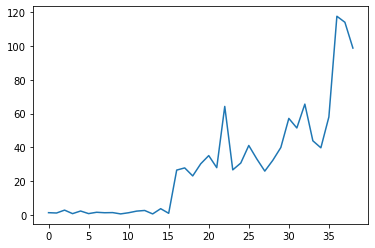

In [94]:
hu_moments_df_sk['Hu1'].plot()

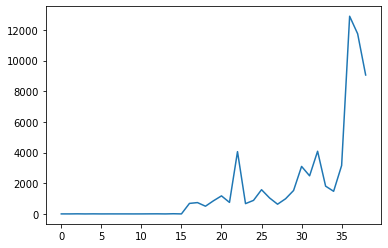

In [95]:
hu_moments_df_sk['Hu2'].plot()

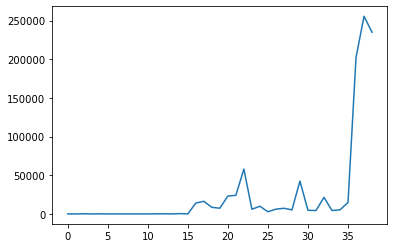

In [96]:
hu_moments_df_sk['Hu3'].plot()

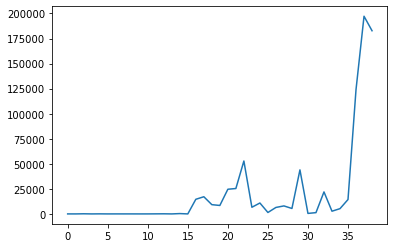

In [97]:
hu_moments_df_sk['Hu4'].plot()

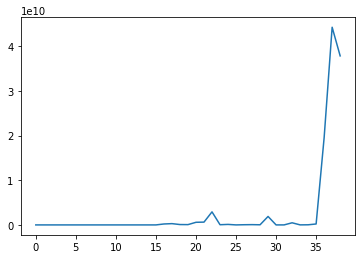

In [98]:
hu_moments_df_sk['Hu5'].plot()

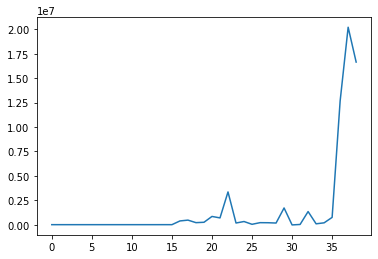

In [99]:
hu_moments_df_sk['Hu6'].plot()

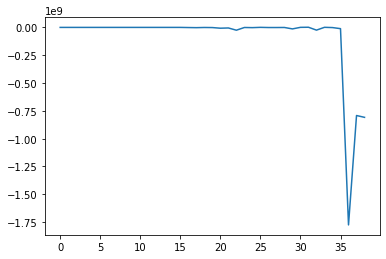

In [100]:
hu_moments_df_sk['Hu7'].plot()

### c. Covaraince Matrix and Eigenvalues

In [101]:
#Covariance matrix and eigenvalues value

In [102]:
#https://alyssaq.github.io/2015/computing-the-axes-or-orientation-of-a-blob/
#Method 1 by calculating coordinates

y, x = np.nonzero(ls_thin_filter_b_image[25]) # x = columns index and y = row index

x = x - np.mean(x)
y = y - np.mean(y)
coords = np.vstack([x, y])

cov = np.cov(coords)
evals, evecs = np.linalg.eig(cov)

sort_indices = np.argsort(evals)[::-1]
x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
x_v2, y_v2 = evecs[:, sort_indices[1]]

In [103]:
def cov_matrix_eigenvalues(file_pil):
    
    if np.invert(file_pil.astype(bool)).all():
        
        return (np.nan,np.nan)
    
    else:
    
        y, x = np.nonzero(file_pil) # x = columns index and y = row index

        x = x - np.mean(x)
        y = y - np.mean(y)
        coords = np.vstack([x, y])

        cov = np.cov(coords)
        evals, evecs = np.linalg.eig(cov)
    
        return (evals[0],evals[1]) #lambda1,lambda2

In [104]:
ls_engin_val = [cov_matrix_eigenvalues(i) if i is not None else (np.nan,np.nan) for i in ls_thin_filter_b_image]
ls_engin_val

[(34920.66238491372, 673.4664389352929),
 (29754.70912880587, 559.4222889511884),
 (57900.95460115153, 3121.2827972224313),
 (27754.77381287318, 768.9831711552733),
 (89456.58417452799, 3780.773275995496),
 (84375.75546829599, 7143.788823418399),
 (45602.45871769524, 2998.472747717833),
 (52071.86628017522, 2881.1320134410707),
 (61335.352100137825, 2924.133314127781),
 (29550.87635314886, 1219.6217458455608),
 (50096.50053325329, 2388.4165263448795),
 (74629.0667240158, 3185.8911918158437),
 (83466.82841969263, 3185.2114645531706),
 (31972.455200376564, 1267.3073811772592),
 (85795.78527744891, 3567.9146314764066),
 (17398.70904531977, 723.8490334435733),
 (196891.47672405659, 2024.295625579668),
 (251780.6277446942, 3920.5119361153083),
 (245102.5414480699, 3887.498897519814),
 (266024.5815056547, 4423.319329735481),
 (247636.33606758097, 3609.498421743104),
 (209592.6510957614, 2515.4420472946376),
 (398298.07791594137, 2959.4927452156007),
 (254396.64382733713, 4079.945211390477),


In [105]:
# ##Method 2 by using central moments

# def raw_moment(data, i_order, j_order):
#     nrows, ncols = data.shape
#     y_indices, x_indicies = np.mgrid[:nrows, :ncols]
#     return (data * x_indicies**i_order * y_indices**j_order).sum()

# def moments_cov(data):
#     data_sum = data.sum()
#     m10 = raw_moment(data, 1, 0)
#     m01 = raw_moment(data, 0, 1)
#     x_centroid = m10 / data_sum
#     y_centroid = m01 / data_sum
#     u11 = (raw_moment(data, 1, 1) - x_centroid * m01) / data_sum
#     u20 = (raw_moment(data, 2, 0) - x_centroid * m10) / data_sum
#     u02 = (raw_moment(data, 0, 2) - y_centroid * m01) / data_sum
#     cov = np.array([[u20, u11], [u11, u02]])
#     return cov

In [106]:
# cov_mo = moments_cov(ls_thin_filter_b_image[25])
# evals_mo, evecs_mo = np.linalg.eig(cov_mo)
# sort_indices_mo = np.argsort(evals_mo)[::-1]
# x_v1_mo, y_v1_mo = evecs_mo[:, sort_indices_mo[0]]  # Eigenvector with largest eigenvalue
# x_v2_mo, y_v2_mo = evecs_mo[:, sort_indices_mo[1]]

In [107]:
#Zernike moments
#import mahotas as mh

In [108]:
# sort_indices

In [109]:
# # Covariance matrix by using Raw moments of Image

# scale = 20

# # plt.subplot(projection = ls_files[23])
# plt.plot([x_v1_mo*-scale*2, x_v1_mo*scale*2],
#          [y_v1_mo*-scale*2, y_v1_mo*scale*2], color='red')
# plt.plot([x_v2_mo*-scale, x_v2_mo*scale],
#          [y_v2_mo*-scale, y_v2_mo*scale], color='blue')
# plt.plot(x, y, 'k.')
# plt.axis('equal')
# # plt.gca().invert_yaxis()  # Match the image system with origin at top left

# # theta = np.arctan((x_v1)/(y_v1))  
# # rotation_mat = np.matrix([[np.cos(theta), -np.sin(theta)],
# #                       [np.sin(theta), np.cos(theta)]])
# # transformed_mat = rotation_mat * coords
# # # plot the transformed blob
# # x_transformed, y_transformed = transformed_mat.A
# # plt.plot(x_transformed, y_transformed, 'g.')

# plt.show()


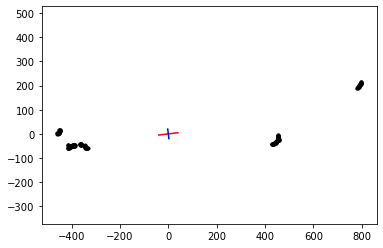

In [110]:
scale = 20

# plt.subplot(projection = ls_files[23])
plt.plot([x_v1*-scale*2, x_v1*scale*2],
         [y_v1*-scale*2, y_v1*scale*2], color='red')
plt.plot([x_v2*-scale, x_v2*scale],
         [y_v2*-scale, y_v2*scale], color='blue')
plt.plot(x, y, 'k.')
plt.axis('equal')
# plt.gca().invert_yaxis()  # Match the image system with origin at top left

# theta = np.arctan((x_v1)/(y_v1))  
# rotation_mat = np.matrix([[np.cos(theta), -np.sin(theta)],
#                       [np.sin(theta), np.cos(theta)]])
# transformed_mat = rotation_mat * coords
# # plot the transformed blob
# x_transformed, y_transformed = transformed_mat.A
# plt.plot(x_transformed, y_transformed, 'g.')

plt.show()

In [111]:
# # ls_files[23].plot()
# plt.contour(ls_thin_filter_b_image[22].astype(bool),antialiased=True,colors='red',linewidths=0.2)

### d. Convexity


In [112]:
# ls_convex_pil_df[20]['perimeter']/ls_str_thin_df[20]['area_thin'].sum()
def convexity_pil(ls_convex_pil_df, ls_str_thin_df):
    
    ls_convexity_pil = []
    
    for i, file in enumerate(ls_convex_pil_df):
        
        if (file is not None) and (len(file) > 0):
            
            conv_val = file['perimeter'].values[0] / ls_str_thin_df[i]['area_thin'].sum()
            
            
            ls_convexity_pil.append(conv_val)
        
        else:
            
            ls_convexity_pil.append(np.nan)
            
    
    return ls_convexity_pil

In [113]:
# ratio of perimeter of convex hull of final PIL(thinned) and number of pixel convered of final PIL()
ls_convexity_pil = convexity_pil(ls_convex_pil_df, ls_str_thin_df)

In [114]:
ls_convexity_pil

[3.1487042736722852,
 4.054800274681324,
 7.133733930809772,
 3.6365109961878423,
 5.575750454811256,
 7.593380747340114,
 5.743674272287215,
 5.0760290666843275,
 4.422814009440465,
 2.7769865710959816,
 5.6517006784454775,
 6.102061325481597,
 5.920400186763492,
 2.9439806992937947,
 12.330757216938501,
 3.436829077867974,
 11.351405390942542,
 13.992996860363705,
 12.36249862483755,
 14.758156089271129,
 19.60002516079712,
 16.77247049777732,
 32.60794841948336,
 16.29971288927717,
 16.814789828347415,
 14.385296035789771,
 12.22331362616845,
 11.832350247403696,
 15.705751652387939,
 12.508647966001982,
 16.64932124881008,
 15.099703332719134,
 13.133858342806228,
 16.349540038064426,
 13.78750793875884,
 13.65737944571684,
 21.137338867388717,
 30.687463346121994,
 20.245126093706904]

In [115]:
# aa_chord = np.array([[1,0,0],[0,1,0],[1,0,0]])

In [116]:
# aa_chord

In [117]:
#Chord distribution

In [118]:
# cr = ps.filters.apply_chords(ls_convex_pil_thin[20].astype(float),axis = 1)

In [119]:
# ax_final_convex_pil = plt.subplot()
# ax_final_convex_pil.imshow(labels > 0,cmap=plt.cm.gray)

In [120]:
# cr.shape

In [121]:
# ls_thin_filter_b_image[20].astype(float)

In [122]:
# labels = label(cr)
# props = regionprops(labels, coordinates='rc')
# chord_lens = np.array([i.filled_area for i in props])

In [123]:
# ps.metrics.chord_length_distribution(cr)

In [124]:
# #Fourior Descriptor
# #https://github.com/timfeirg/Fourier-Descriptors/blob/master/FourierDescriptor.py


In [125]:
# #Fourior Descriptor???
##Apply Fourior transform on PIL

# a_fft2 = scipy.fftpack.fft2(ls_thin_filter_b_image[22].astype(float))

In [126]:
# a_fft2 = scipy.fftpack.fft(ls_thin_filter_b_image[22].astype(float).flatten())

In [127]:
# a_fft2[0:10]

In [128]:
# abs(a_fft2).max()

In [129]:
# a_fft2[1].imag

In [130]:
# bbb = np.zeros(a_fft2.shape)
# bbb[:100] = a_fft2[:100]
# # bbb[-10000:] = a_fft2[-10000:]

In [131]:
# bbb

In [132]:
# a_shift_fft = np.fft.fftshift(a_fft2)

In [133]:


# b_ff2_real = np.array([i if abs(i) > 4000 else 0 for i in a_fft2.real])

In [134]:
# np.array(b_ff2_real)

In [135]:
# plt.plot(a_fft2.real)

In [136]:
# a_fft2.real[1]

In [137]:
# plt.plot(abs(np.array(b_ff2_real)))

In [138]:
# plt.hist(abs(a_fft2.imag))

In [139]:
# plt.plot(abs(a_fft2.imag),'r-')
# # plt.plot(a_fft2.imag,'b-')

In [140]:
# b_ff2_imag = np.array([i if abs(i) > 3000 else 0 for i in a_fft2.imag])

In [141]:
# plt.plot(abs(b_ff2_imag),'r-')
# # plt.plot(a_fft2.imag,'b-')

In [142]:
# a_fft2.real

In [143]:
# * np.exp(phase_response_moon)

In [144]:
# a_fft2.imag

In [145]:
# b_ff2_real = b_ff2_real.reshape(ls_thin_filter_b_image[22].shape)
# b_ff2_imag = b_ff2_imag.reshape(ls_thin_filter_b_image[22].shape)

In [146]:
# np.angle(a_fft2)

In [147]:
# combined_1 = abs(scipy.fftpack.ifft2(a_fft2))#inverse Fourier transform
# plt.figure()
# plt.imshow(combined_1, plt.cm.gray)

In [148]:
# combined_1 = abs(scipy.fftpack.ifft(a_fft2))#inverse Fourier transform
# plt.figure()
# plt.imshow(combined_1.reshape(ls_thin_filter_b_image[22].shape), plt.cm.gray)

In [149]:
# combined_1.max()

In [150]:
# from sklearn.metrics import mean_squared_error
# import math
# mse_1 = mean_squared_error(ls_thin_filter_b_image[22].astype(float).flatten(), combined_1)
# mse_1
# math.sqrt(mse_1)

In [151]:
# combined_2 = abs(scipy.fftpack.ifft(bbb))#inverse Fourier transform
# plt.figure()
# plt.imshow(combined_2.reshape(ls_thin_filter_b_image[22].shape), plt.cm.gray)

In [152]:
# combined_2.min()

In [153]:
# mse_1 = mean_squared_error(ls_thin_filter_b_image[22].astype(float).flatten(), combined_2)
# mse_1
# math.sqrt(mse_1)

In [154]:
# plt.imshow(ls_thin_filter_b_image[22], plt.cm.gray)